In [1]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):

    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coeffient
    # sigma: standard deviatin of the error term

    m = 1 / np.sqrt(1 - rho**2)

    # compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n-1)

    # compute the transition probabilities
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j==0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j==n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):

    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coeffient
    # sigma: standard deviatin of the error term

    m = 1 / np.sqrt(1 - rho**2)

    # compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n-1)

    # compute the transition probabilities
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j==0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j==n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space
# function to compile parameters into one thing "param"
def setPar(
    sigma = 1.5, # risk aversion
    beta = 0.98, # subject discount factor
    rho = 0.6, # labor productivity persistence
    sigma_eps = 0.6, # labor productivity std
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NA = 401, # number of grids of a
    NH = 2, # number of grids of h
    mu_h = -0.7, # mean of log h
    alpha = 0.25,
    delta = 0.03,
    ):

    # # create a grid of asset holdings
    # a = np.linspace(a_l, a_u, NA)

    # making grids for ln h and solving for income transition probability using Tauchen's method
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    # create dictionary with parameters
    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u
    param['alpha'] = alpha
    param['delta'] = delta

    return param

def solve_household(param, r, w):
    # opening the box of param
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    util = np.full((NA, NA, NH), -10000.0)
    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    # iterate on bellman's equation and get the decision rules and the value function
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol: # loop until value function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c


def get_distribution(param, decisions):

    NA = param['NA']
    NH = param['NH']
    iaplus = decisions[1]
    pi = param['pi']

    test = 10 # initialize a test value to be greater than 1e-8
    phi = np.ones((NA, NH))/NA/NH # initialize the distribution phi to be uniform

    # loop until the test value is less than 1e-8
    while test > 1e-8:
        phi_new = np.zeros((NA, NH)) # initialize a new distribution phi_new to be all zero values
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]

        test = np.max(np.abs(phi_new - phi)) # calculate the maximum difference
        phi = phi_new # update phi to be phi_new

    return phi




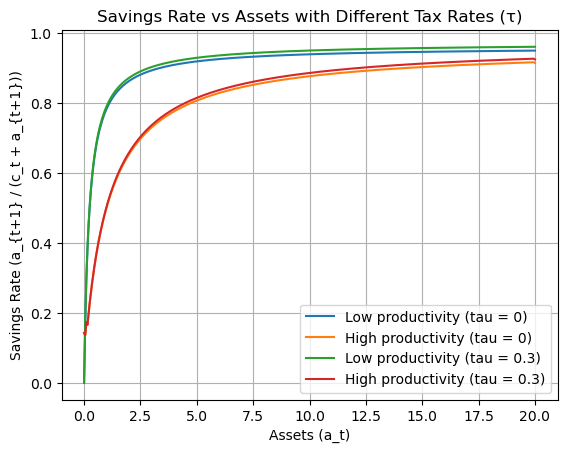

In [8]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Tauchen method to discretize the AR(1) process for labor productivity
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m * sigma, mu + m * sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, n - 1] = 1 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
    return transition_matrix, state_space

# Set parameters for the model
def set_parameters(tau, sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)  # Convert to exponential to get actual productivity levels
    parameters = {
        'sigma': sigma,
        'beta': beta,
        'pi': pi,
        'h': h,
        'NA': NA,
        'NH': NH,
        'a_l': a_l,
        'a_u': a_u,
        'alpha': alpha,
        'delta': delta,
        'tau': tau
    }
    return parameters

# Solve the household problem
def solve_household(parameters, r, w):
    NA, NH, h, a_l, a_u, sigma, beta, pi, tau = (
        parameters['NA'], parameters['NH'], parameters['h'], parameters['a_l'], 
        parameters['a_u'], parameters['sigma'], parameters['beta'], parameters['pi'], parameters['tau']
    )
    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility for all state-action pairs
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1 + (1 - tau) * r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons ** (1 - sigma) / (1 - sigma)

    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    tol, test = 1e-6, 10.0
    reward = np.zeros((NA, NA, NH))

    # Value function iteration
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus]

    # Calculate consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1 + (1 - tau) * r) * a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

# Get the distribution of assets
def get_distribution(parameters, decisions):
    NA, NH, iaplus, pi = parameters['NA'], parameters['NH'], decisions[1], parameters['pi']
    test, phi = 10, np.ones((NA, NH)) / NA / NH

    while test > 1e-8:
        phi_new = np.zeros((NA, NH))
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]
        test = np.max(np.abs(phi_new - phi))
        phi = phi_new

    return phi

# Plotting the savings rate
def plot_savings_rate(parameters_list, r, w):
    for parameters in parameters_list:
        decisions = solve_household(parameters, r, w)
        aplus, c = decisions[0], decisions[2]
        a = np.linspace(parameters['a_l'], parameters['a_u'], parameters['NA'])
        label = f'tau = {parameters["tau"]}'
        plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label=f'Low productivity ({label})')
        plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label=f'High productivity ({label})')

    plt.xlabel("Assets (a_t)")
    plt.ylabel("Savings Rate (a_{t+1} / (c_t + a_{t+1}))")
    plt.title("Savings Rate vs Assets with Different Tax Rates (τ)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters for different tax rates
tau_values = [0, 0.3]
r, w = 0.04, 1
parameters_list = [set_parameters(tau) for tau in tau_values]

plot_savings_rate(parameters_list, r, w)


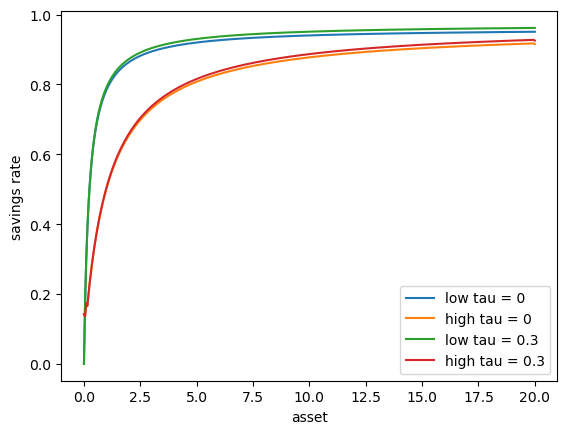

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Tauchen method to discretize the AR(1) process for labor productivity
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m * sigma, mu + m * sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, n - 1] = 1 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
    return transition_matrix, state_space

# Set parameters
def setPar(tau, sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma,
        'beta': beta,
        'pi': pi,
        'h': h,
        'NA': NA,
        'NH': NH,
        'a_l': a_l,
        'a_u': a_u,
        'alpha': alpha,
        'delta': delta,
        'tau': tau
    }
    return param

# Solve household problem
def solve_household(param, r, w):
    NA, NH, h, a_l, a_u, sigma, beta, pi, tau = param['NA'], param['NH'], param['h'], param['a_l'], param['a_u'], param['sigma'], param['beta'], param['pi'], param['tau']
    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)



    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1 + (1 - tau) * r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons ** (1 - sigma) / (1 - sigma)



    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)



    tol, test = 1e-6, 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])


        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus]



    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1 + (1 - tau) * r) * a[ia] - aplus[ia, ih]

    return aplus, iaplus, c


# Get distribution
def get_distribution(param, decisions):
    NA, NH, iaplus, pi = param['NA'], param['NH'], decisions[1], param['pi']
    test, phi = 10, np.ones((NA, NH)) / NA / NH

    while test > 1e-8:
        phi_new = np.zeros((NA, NH))
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]
        test = np.max(np.abs(phi_new - phi))
        phi = phi_new

    return phi



# Plotting function
def plot_savings_rate(param_list, r, w):
    for param in param_list:
        decisions = solve_household(param, r, w)
        aplus, c = decisions[0], decisions[2]
        a = np.linspace(param['a_l'], param['a_u'], param['NA'])
        label = f'tau = {param["tau"]}'
        plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label=f'low {label}')
        plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label=f'high {label}')

    plt.xlabel("asset")
    plt.ylabel("savings rate")
    plt.legend()
    plt.show()

# Parameters
tau_values = [0, 0.3]
r, w = 0.04, 1
param_list = [setPar(tau) for tau in tau_values]

plot_savings_rate(param_list, r, w)


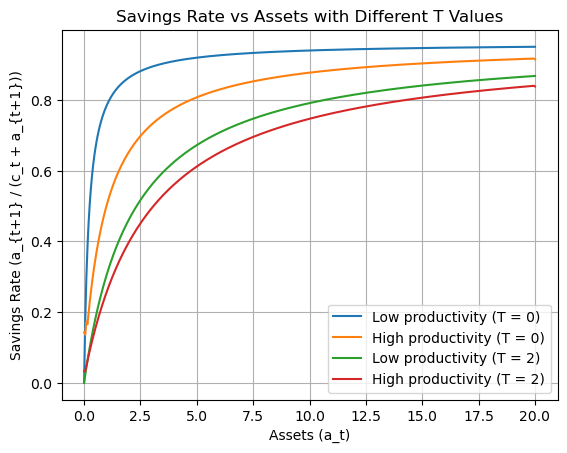

In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Tauchen method to discretize the AR(1) process for labor productivity
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m * sigma, mu + m * sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, n - 1] = 1 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)

    return transition_matrix, state_space

# Set parameters for the model
def set_parameters(T, sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)  # Convert to exponential to get actual productivity levels
    parameters = {
        'sigma': sigma,
        'beta': beta,
        'pi': pi,
        'h': h,
        'NA': NA,
        'NH': NH,
        'a_l': a_l,
        'a_u': a_u,
        'alpha': alpha,
        'delta': delta,
        'T': T
    }
    return parameters

# Solve the household problem
def solve_household(parameters, r, w):
    NA, NH, h, a_l, a_u, sigma, beta, pi, T = parameters['NA'], parameters['NH'], parameters['h'], parameters['a_l'], parameters['a_u'], parameters['sigma'], parameters['beta'], parameters['pi'], parameters['T']
    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)

    # Utility calculation
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1 + r) * a[ia] + T - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons ** (1 - sigma) / (1 - sigma)

    # Value function iteration
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol, test = 1e-6, 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus]

    # Consumption calculation
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1 + r) * a[ia] + T - aplus[ia, ih]

    return aplus, iaplus, c

# Get distribution function
def get_distribution(parameters, decisions):
    NA, NH, iaplus, pi = parameters['NA'], parameters['NH'], decisions[1], parameters['pi']
    test, phi = 10, np.ones((NA, NH)) / (NA * NH)

    while test > 1e-8:
        phi_new = np.zeros((NA, NH))
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]
        test = np.max(np.abs(phi_new - phi))
        phi = phi_new

    return phi

# Plotting function
def plot_savings_rate(param_list, r, w):
    for param in param_list:
        decisions = solve_household(param, r, w)
        aplus, c = decisions[0], decisions[2]
        a = np.linspace(param['a_l'], param['a_u'], param['NA'])
        label = f'T = {param["T"]}'
        plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label=f'Low productivity ({label})')
        plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label=f'High productivity ({label})')

    plt.xlabel("Assets (a_t)")
    plt.ylabel("Savings Rate (a_{t+1} / (c_t + a_{t+1}))")
    plt.title("Savings Rate vs Assets with Different T Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters for different values of T
T_values = [0, 2]  # Government lump-sum transfer amounts set to 0 and 2
r, w = 0.04, 1
param_list = [set_parameters(T) for T in T_values]

# Plot the savings rate
plot_savings_rate(param_list, r, w)


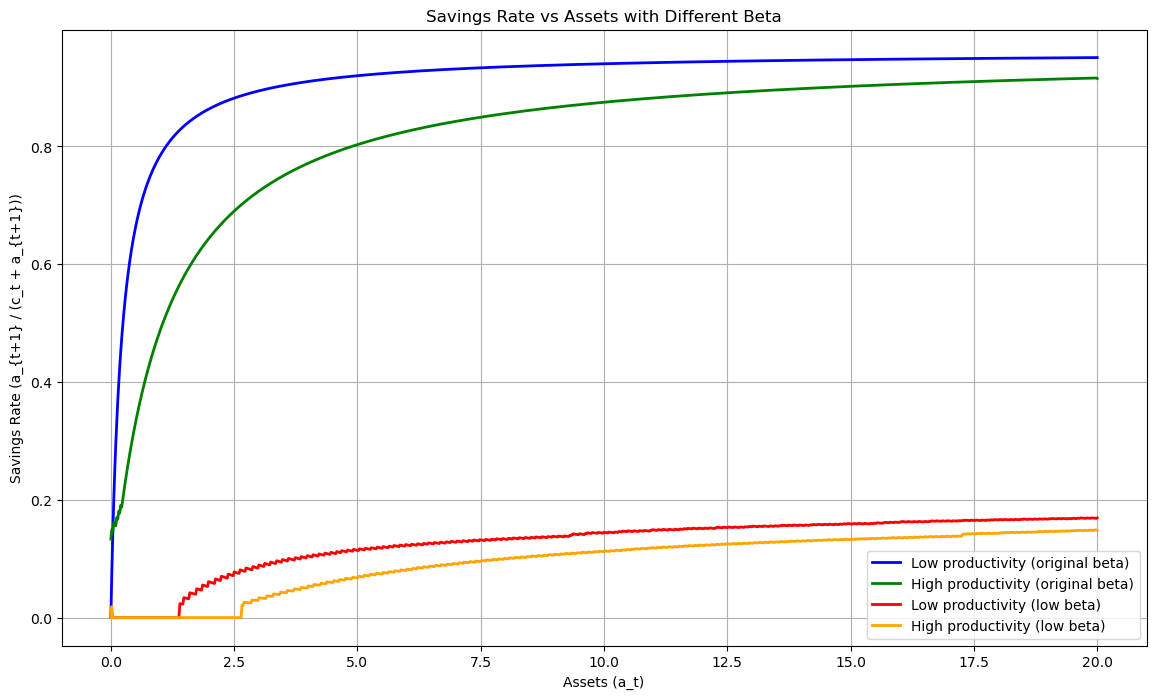

In [6]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Tauchen method to discretize the AR(1) process for labor productivity
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m * sigma, mu + m * sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, n - 1] = 1.0 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
                
    return transition_matrix, state_space

# Set parameters for the model
def set_parameters(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=1001, NH=2, mu_h=-0.7):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)  # Convert to exponential to get actual productivity levels
    parameters = {
        'sigma': sigma,
        'beta': beta,
        'pi': pi,
        'h': h,
        'NA': NA,
        'NH': NH,
        'a_l': a_l,
        'a_u': a_u
    }
    return parameters

# Solve the household problem
def solve_household(parameters, beta=None, r=0.04, w=1):
    if beta is None:
        beta = parameters['beta']
    
    NA = parameters['NA']
    NH = parameters['NH']
    h = parameters['h']
    a_l = parameters['a_l']
    a_u = parameters['a_u']
    sigma = parameters['sigma']
    pi = parameters['pi']
    
    a = np.linspace(a_l, a_u, NA)
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)
    
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)
                    
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))
    
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
                
        test = np.max(abs(v_new - v))
        v = v_new
        
    aplus = a[iaplus]
    
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih]
            
    return aplus, iaplus, c

# Set initial parameters and solve the household problem
param = set_parameters(beta=0.98, sigma_eps=0.6, NA=1001)
aplus, iaplus, c = solve_household(param)

# Set low beta parameters and solve the household problem
param_low_beta = set_parameters(beta=0.1, sigma_eps=0.6, NA=1001)
aplus_low_beta, iaplus_low_beta, c_low_beta = solve_household(param_low_beta, beta=0.1)

# Assets range
a = np.linspace(param['a_l'], param['a_u'], param['NA'])

# Plotting the graph
plt.figure(figsize=(14, 8))
plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label='Low productivity (original beta)', color='blue', linewidth=2)
plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label='High productivity (original beta)', color='green', linewidth=2)
plt.plot(a, aplus_low_beta[:, 0] / (c_low_beta[:, 0] + aplus_low_beta[:, 0]), label='Low productivity (low beta)', color='red', linewidth=2)
plt.plot(a, aplus_low_beta[:, 1] / (c_low_beta[:, 1] + aplus_low_beta[:, 1]), label='High productivity (low beta)', color='orange', linewidth=2)
plt.xlabel("Assets (a_t)")
plt.ylabel("Savings Rate (a_{t+1} / (c_t + a_{t+1}))")
plt.title("Savings Rate vs Assets with Different Beta")
plt.legend()
plt.grid(True)
plt.show()
